In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import glob
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, make_scorer


In [4]:
file_list = glob.glob('data/tles/*.csv')

In [5]:
df_list = []
for file in file_list:
    df = pd.read_csv(file)
    df_list.append(df)

In [6]:
all_tle_df = pd.concat(df_list, ignore_index=True)
all_tle_df.drop_duplicates(inplace=True)

In [7]:
all_tle_df.to_csv('all_tle_merged.csv', index=False)

In [8]:
decay_df = pd.read_csv('data/decay_data.csv')


In [9]:
decay_df = decay_df[['NORAD_CAT_ID', 'DECAY_EPOCH']]
decay_df['DECAY_EPOCH'] = pd.to_datetime(decay_df['DECAY_EPOCH'], errors='coerce')
decay_df.dropna(subset=['DECAY_EPOCH'], inplace=True)
decay_df

,NORAD_CAT_ID,DECAY_EPOCH
0,15830,2024-07-31 17:43:00
1,15830,2024-07-31 17:43:00
2,15830,2024-07-31 17:42:00
3,12755,2024-07-31 00:00:00
4,12755,2024-07-31 00:00:00
...,...,...
991,47599,2024-07-01 00:00:00
992,47644,2024-07-01 00:00:00
993,50284,2024-07-01 00:00:00
994,55694,2024-07-01 00:00:00


In [10]:
all_tle_df['EPOCH'] = pd.to_datetime(all_tle_df['EPOCH'], errors='coerce')
all_tle_df.dropna(subset=['EPOCH'], inplace=True)

In [11]:
merged_df = all_tle_df.merge(decay_df, on='NORAD_CAT_ID', how='inner')
merged_df.describe()

,NORAD_CAT_ID,EPOCH,EPOCH_MICROSECONDS,MEAN_MOTION,ECCENTRICITY,INCLINATION,RA_OF_ASC_NODE,ARG_OF_PERICENTER,MEAN_ANOMALY,EPHEMERIS_TYPE,...,MEAN_MOTION_DOT,MEAN_MOTION_DDOT,FILE,OBJECT_NUMBER,SEMIMAJOR_AXIS,PERIOD,APOGEE,PERIGEE,DECAYED,DECAY_EPOCH
count,862098.000000,862098,862098.00000,862098.000000,862098.000000,862098.000000,862098.000000,862098.000000,862098.000000,862098.0,...,862098.000000,862098.000000,8.620980e+05,862098.000000,862098.000000,862098.000000,862098.000000,862098.000000,862098.0,862098
mean,24522.528490,2012-03-16 04:46:20.681221376,501915.68261,13.780851,0.064615,74.171906,179.934232,174.655299,183.817129,0.0,...,0.000448,0.013196,1.914167e+06,24522.528490,7941.348923,122.675063,2587.229293,539.198549,1.0,2024-07-25 12:50:16.269357824
min,12755.000000,1979-07-18 07:55:00,0.00000,2.305852,0.000004,31.548600,0.002800,0.004100,0.010200,0.0,...,-0.017860,-0.000004,1.150000e+02,12755.000000,6518.937000,87.302000,148.853000,120.720000,1.0,2024-07-10 00:00:00
25%,14819.000000,2003-12-19 00:39:00,246368.00000,14.337540,0.001158,71.170800,89.862500,82.358400,87.165400,0.0,...,0.000010,0.000000,1.458150e+05,14819.000000,6889.328000,94.847000,521.062000,469.886000,1.0,2024-07-23 21:09:00
50%,14819.000000,2016-04-21 12:25:00,503135.00000,14.872435,0.001577,82.530700,179.868000,171.032200,187.322700,0.0,...,0.000026,0.000000,2.024254e+06,14819.000000,6984.694000,96.823000,618.940000,537.061000,1.0,2024-07-25 00:00:00
75%,37159.000000,2022-05-19 20:00:00,757792.00000,15.182312,0.003996,82.909500,269.543800,265.468500,281.242900,0.0,...,0.000131,0.000000,3.453579e+06,37159.000000,7157.352000,100.436000,796.040000,650.588000,1.0,2024-07-26 04:46:00
max,58144.000000,2024-07-24 23:56:00,999999.00000,16.494439,0.728352,98.705400,359.993700,359.999000,359.992900,0.0,...,0.299813,9.989100,4.696375e+06,58144.000000,24201.806000,624.498000,35363.109000,2394.662000,1.0,2024-07-31 00:00:00
std,14947.749621,NaN,294475.61713,3.220515,0.177648,19.373987,103.836891,103.936766,108.708281,0.0,...,0.003412,0.290181,1.576124e+06,14947.749621,2960.471432,82.306371,6029.581642,181.545297,0.0,NaN


In [12]:
merged_df['days_to_decay'] = (merged_df['DECAY_EPOCH'] - merged_df['EPOCH']).dt.days
merged_df['days_to_decay'].describe()

count    862098.000000
mean       4513.864518
std        4213.801043
min         -13.000000
25%         797.000000
50%        3016.000000
75%        7524.000000
max       16447.000000
Name: days_to_decay, dtype: float64

In [13]:
merged_df = merged_df[merged_df['days_to_decay'] >= 0]

In [32]:
features_df = merged_df[['NORAD_CAT_ID', 'EPOCH', 'MEAN_MOTION', 'ECCENTRICITY', 'INCLINATION', 'BSTAR', 'days_to_decay']]
features_df.to_csv('features.csv', index=False)

In [15]:
features = ['MEAN_MOTION', 'ECCENTRICITY', 'INCLINATION', 'BSTAR']
X = features_df[['MEAN_MOTION', 'ECCENTRICITY', 'INCLINATION', 'BSTAR']]
y = features_df['days_to_decay']
y

0           4
1           4
2           0
3           0
4           0
         ... 
862093    511
862094    510
862095    511
862096    511
862097    510
Name: days_to_decay, Length: 861985, dtype: int64

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [24]:
rf_y_pred = rf_model.predict(X_test)

In [25]:
mae = mean_absolute_error(y_test, rf_y_pred)
print(f'Mean Absolute Error on Test Set: {mae:.2f} days') 

Mean Absolute Error on Test Set: 2.27 days


<BarContainer object of 4 artists>

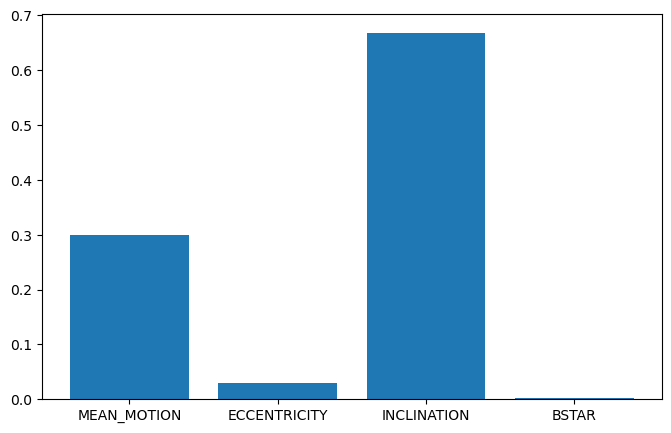

In [26]:
importances = rf_model.feature_importances_
plt.figure(figsize=(8,5))
plt.bar(features, importances)


In [29]:
xgb_model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=4,
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=-1, num_parallel_tree=None, ...)

In [30]:
xgb_y_pred = xgb_model.predict(X_test)
xgb_mae = mean_absolute_error(y_test, xgb_y_pred)
print(f'XGBoost MAE on Test Set: {xgb_mae:.2f} days')

XGBoost MAE on Test Set: 278.31 days
